## Dependecies


In [2]:
from pathlib import Path
import sys
import copy
from torchvision import datasets

In [5]:
project_root = Path.cwd().resolve().parents[2]
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

data_root = project_root / "data"
data_root.mkdir(parents=True, exist_ok=True)

In [7]:
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from tqdm import tqdm, trange
import numpy as np

## Utils


In [8]:
# Device configuration
from utils.utils import DEVICE

print(f"Device used: {DEVICE}")

# Set random seed for reproducibility
from utils.utils import set_seed

set_seed()

from utils.utils import save_model

from models.resnet50 import load_model_resnet50, init_model_resnet50

# Merics
from utils.train_test_metrics import test_model, show_metrics

# Recreate Dataloaders from json files
from methods.naive.naive_utils import recreate_dataloaders

# # Fisher Information Matrix (FIM) calc and unlearning with FIM
from methods.fisher.fisher_utils import create_unlearning_dataloader

Device used: cuda


## Parameters (arbitrary chosen)


In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [9]:
BATCH_SIZE = 64
MINI_BATCH_SIZE = 1024

EPS = 1000
MAX_NORM = 10  # 0.5
CG_ITERS = 5
SCALE = 1e3

# CALL FISHER


### Files


In [10]:
naive_results_path = Path("D:/Unlearning/results/cifar10/naive")
results_path = Path("D:/Unlearning/results/cifar10/influence")

model_file = naive_results_path / "ResNet50_CIFAR10_model.pth"
samples_to_unlearn_file = (
    naive_results_path / "cifar10_samples_to_unlearn_30per.json"
)
remaining_dataset_file = (
    naive_results_path / "updated_cifar10_data_splits.json"
)

### Init models


In [11]:
original_model, original_model_name, criterion, _optimizer, transform = (
    load_model_resnet50(model_pth_path=model_file)
)

model_to_unlearn = copy.deepcopy(original_model)
model_to_unlearn_name = "influence_" + original_model_name

# import torch.nn as nn

# model_to_unlearn = nn.DataParallel(model_to_unlearn, device_ids=[0, 1])

Load model...
Init model...
Done initializing model.
Model ID: 1888046956448, Optimizer ID: 1888047841136, Criterion ID: 1888047841184
Done loading model.


## Init data


In [12]:
train_dataset = datasets.CIFAR10(
    root=data_root, train=True, transform=transform, download=True
)
test_dataset = datasets.CIFAR10(
    root=data_root, train=False, transform=transform, download=True
)

In [13]:
from methods.fisher.fisher_utils import create_unlearning_dataloader

In [ ]:
unlearn_indices, unlearn_loader = create_unlearning_dataloader(
    samples_to_unlearn_file, train_dataset, batch_size=MINI_BATCH_SIZE
)

In [ ]:
# train_loader, _val_loader, test_loader, classes = recreate_dataloaders(
#     data_splits_file=remaining_dataset_file,
#     datasets=(train_dataset, test_dataset),
#     batch_size=BATCH_SIZE)

# unlearn_loader = create_unlearning_dataloader(samples_to_unlearn_file, train_dataset, batch_size = MINI_BATCH_SIZE)

### TUTAJ COS


In [ ]:
from torch.amp import GradScaler, autocast

scaler = GradScaler()
import math


def compute_gradient_on_subset(model, criterion, dataset_subset, batch_size):
    """
    Compute the average gradient Δ = (1/|D_u|) Σ_{(x,y) in D_u} ∇_θ L(θ, (x,y))
    over the dataset_subset.
    """
    dataloader = DataLoader(dataset_subset, batch_size=batch_size, shuffle=False)

    grad_dict = {
        name: torch.zeros_like(param, device=DEVICE)
        for name, param in model.named_parameters()
        if param.requires_grad
    }

    total_samples = 0

    model.train()  # ensure gradients are computed
    for inputs, targets in tqdm(dataloader, desc="Computing gradients"):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        with autocast(device_type=str(DEVICE)):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()

        current_batch = inputs.size(0)
        total_samples += current_batch

        for name, param in model.named_parameters():
            if param.requires_grad and param.grad is not None:
                grad_dict[name] += param.grad.detach().clone() * current_batch

    # Average over total samples
    for name in grad_dict:
        grad_dict[name] /= total_samples

    # Flatten all gradients into one vector
    grad_vector = torch.cat(
        [grad_dict[name].view(-1) for name in sorted(grad_dict.keys())]
    )
    return grad_vector


def lissa_inverse_hvp(
    model, criterion, data_loader, v, damping=EPS, scale=SCALE, recursion_depth=20
):
    ihvp_estimate = v.clone().to(DEVICE)
    data_iter = iter(data_loader)
    model.train()

    for _ in trange(recursion_depth, desc="LiSSA iterations", leave=False):
        try:
            inputs, targets = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            inputs, targets = next(data_iter)

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        with autocast(device_type=str(DEVICE)):
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)

        hv = torch.autograd.grad(
            torch.dot(grad_vector, ihvp_estimate),
            model.parameters(),
            retain_graph=False,
        )
        hv_vector = torch.cat([h.reshape(-1) for h in hv])

        # LiSSA recursive update
        ihvp_estimate = v + (1 - damping) * ihvp_estimate - hv_vector / scale

    return ihvp_estimate / scale


def lissa_inverse_hvp(
    model, criterion, data_loader, v, damping=EPS, scale=SCALE, recursion_depth=20
):
    ihvp_estimate = v.clone().to(DEVICE)
    data_iter = iter(data_loader)
    model.train()

    for step in trange(recursion_depth, desc="LiSSA iterations", leave=False):
        try:
            inputs, targets = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            inputs, targets = next(data_iter)

        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        model.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)

        if torch.isnan(grad_vector).any() or torch.isinf(grad_vector).any():
            print(f"🚨 [Debug] Step {step}: grad_vector has NaN/Inf!")
            return torch.zeros_like(v)

        hv = torch.autograd.grad(
            torch.dot(grad_vector, ihvp_estimate),
            model.parameters(),
            retain_graph=False,
        )
        hv_vector = torch.cat([h.reshape(-1) for h in hv])

        if torch.isnan(hv_vector).any() or torch.isinf(hv_vector).any():
            print(
                f"🚨 [Debug] Step {step}: Hessian-vector product (hv_vector) has NaN/Inf!"
            )
            return torch.zeros_like(v)

        ihvp_estimate = v + (1 - damping) * ihvp_estimate - hv_vector / scale

        if torch.isnan(ihvp_estimate).any() or torch.isinf(ihvp_estimate).any():
            print(f"🚨 [Debug] Step {step}: LiSSA update (ihvp_estimate) has NaN/Inf!")
            return torch.zeros_like(v)

    print("✅ [Debug] LiSSA estimation stable.")
    return ihvp_estimate / scale


# -----------------------------
# Helper Function: Hessian-Vector Product (HVP)
# -----------------------------
def hessian_vector_product(model, criterion, data_loader, v, damping=0.0):
    """
    Compute Hessian-vector product: Hv, averaged over the data in data_loader.
    This version is more vectorized by converting the gradients into a single flattened vector.
    """
    model.zero_grad()
    hvp_total = 0.0
    total_batches = 0

    for inputs, targets in data_loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        # Compute gradients as a vector
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)
        grad_vector = torch.nn.utils.parameters_to_vector(grads)
        # Dot product with v
        grad_dot_v = torch.dot(grad_vector, v)
        # Compute second derivative: gradient of grad_dot_v w.r.t parameters
        hv = torch.autograd.grad(grad_dot_v, model.parameters(), retain_graph=False)
        # Use reshape instead of view to avoid contiguity issues
        hv_vector = torch.cat([h.reshape(-1) for h in hv])
        hvp_total += hv_vector
        total_batches += 1

    hvp_total /= total_batches
    return hvp_total + damping * v


# -----------------------------
# Helper Function: Conjugate Gradient (CG) Solver
# -----------------------------
def conjugate_gradient_solver(
    model, criterion, data_loader, b, cg_iters=50, residual_tol=1e-3, damping=0.0
):
    """
    Solve Hx = b using Conjugate Gradient, where H is the Hessian computed on data_loader.
    Returns x ≈ H⁻¹ b.
    """
    x = torch.zeros_like(b, device=DEVICE)
    r = b.clone().to(DEVICE)
    p = r.clone().to(DEVICE)
    rdotr = torch.dot(r, r)

    for i in trange(cg_iters, desc="CG iterations", leave=False):
        Hp = hessian_vector_product(model, criterion, data_loader, p, damping)
        alpha = rdotr / (torch.dot(p, Hp) + 1e-8)
        x = x + alpha * p
        r = r - alpha * Hp
        new_rdotr = torch.dot(r, r)
        if new_rdotr < residual_tol:
            break
        beta = new_rdotr / (rdotr + 1e-8)
        p = r + beta * p
        rdotr = new_rdotr
    return x


# -----------------------------
# Main Function: Iterative Influence Unlearning
# -----------------------------
def iterative_influence_unlearn(
    model,
    criterion,
    full_dataset,
    removal_indices,
    deletion_batch_size,
    compute_batch_size,
    eps,
    max_norm,
    cg_iters=50,
):
    """
    Implements iterative Influence Unlearning:
      For each mini-batch of deletion samples, compute the average gradient
      Δ_u, solve v ≈ H⁻¹ Δ_u using Conjugate Gradient on the remaining data,
      and update the model as: θ ← θ + v.

    Mathematical Equations:
      Δ_u = (1/|D_u^i|) Σ_{(x,y) in D_u^i} ∇_θ L(θ, (x,y))
      v ≈ H⁻¹ Δ_u,  where H = ∇²_θ L(θ, D \ D_u^i)
      θ ← θ + v
    """
    full_size = len(full_dataset)
    current_indices = set(range(full_size))

    # Partition removal_indices into mini-batches
    removal_list = list(removal_indices)
    num_batches = math.ceil(len(removal_list) / deletion_batch_size)
    partitioned_removals = [
        removal_list[i * deletion_batch_size : (i + 1) * deletion_batch_size]
        for i in range(num_batches)
    ]
    print(
        f"Total deletion samples: {len(removal_list)}; partitioned into {num_batches} mini-batches (each up to {deletion_batch_size} samples)."
    )

    for i, batch in enumerate(tqdm(partitioned_removals, desc="Influence Unlearning")):
        # Update remaining indices: D_current ← D \ D_u^i
        current_indices -= set(batch)
        updated_indices = sorted(list(current_indices))
        dataset_remaining = Subset(full_dataset, updated_indices)
        print(
            f"Iteration {i+1}/{num_batches}: Remaining dataset size = {len(dataset_remaining)}"
        )

        # Compute average gradient Δ_u for the deletion mini-batch
        deleted_subset = Subset(full_dataset, batch)
        delta = compute_gradient_on_subset(
            model, criterion, deleted_subset, compute_batch_size
        )

        if torch.isnan(delta).any() or torch.isinf(delta).any():
            print("🚨 [Debug] Gradient delta contains NaN/Inf!")
        else:
            print("✅ [Debug] Gradient delta stable.")

        # Create a DataLoader for remaining data to approximate Hessian
        remaining_loader = DataLoader(
            dataset_remaining, batch_size=compute_batch_size, shuffle=True
        )

        # # Solve for influence update: v ≈ H⁻¹ Δ_u using Conjugate Gradient
        # influence_update = conjugate_gradient_solver(model, criterion, remaining_loader, delta, cg_iters=cg_iters, damping=eps)

        influence_update = lissa_inverse_hvp(
            model,
            criterion,
            remaining_loader,
            delta,
            damping=eps,
            scale=SCALE,
            recursion_depth=cg_iters,
        )
        # Optionally clip the update to avoid overly large changes
        update_norm = influence_update.norm(2).item()
        if update_norm > max_norm or math.isnan(update_norm) or math.isinf(update_norm):
            print(
                f"WARNING: Clipping influence update from {update_norm:.2f} to {max_norm}"
            )
            influence_update = influence_update * (max_norm / update_norm)
        print(
            f"Iteration {i+1}: Influence update norm = {influence_update.norm(2).item():.4f}"
        )

        # Update model parameters: θ ← θ + v
        pointer = 0
        with torch.no_grad():
            for name, param in model.named_parameters():
                if param.requires_grad:
                    numel = param.numel()
                    update_segment = influence_update[
                        pointer : pointer + numel
                    ].view_as(param)
                    param.data = param.data + update_segment
                    pointer += numel
        print(f"Iteration {i+1}/{num_batches} update completed.")

    return model

In [ ]:
import time

start_time = time.perf_counter()


try:
    # Your main influence unlearning script goes here.
    unlearned_model = iterative_influence_unlearn(
        model_to_unlearn,
        criterion,
        train_dataset,
        unlearn_indices,
        MINI_BATCH_SIZE,
        BATCH_SIZE,
        EPS,
        MAX_NORM,
        CG_ITERS,
    )
except Exception as e:
    print("An error occurred:", e)
finally:
    # Explicitly release GPU memory
    torch.cuda.empty_cache()
    gc.collect()
    print("Cleaned up GPU memory.")

end_time = time.perf_counter()  # End timer
elapsed_time = end_time - start_time

print(f"Execution time: {elapsed_time:.6f} seconds")

In [ ]:
save_model(unlearned_model, f"{model_to_unlearn_name}_model1.pth")

### Test and metrics


In [14]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
classes = test_dataset.classes

In [20]:
model, *_ = init_model_resnet50()


# import torch.nn as nn

# model = nn.DataParallel(model, device_ids=[0, 1])


model_path = results_path / f"{model_to_unlearn_name}_model.pth"
test_model(model, model_to_unlearn_name, model_path, test_loader, results_path=results_path)
# test_model(model, model_to_unlearn_name, model_path, unlearn_loader)

Init model...
Done initializing model.
Model ID: 1888047644736, Optimizer ID: 1888496430880, Criterion ID: 1888496430928
Loading and testing model: influence_ResNet50_CIFAR10


Evaluating model: D:\Unlearning\results\cifar10\influence\influence_ResNet50_CIFAR10_model.pth: 100%|██████████| 157/157 [00:34<00:00,  4.54it/s]

Predictions and labels saved to influence_ResNet50_CIFAR10_predictions.json


Metrics for influence_ResNet50_CIFAR10:
  - Test Accuracy: 0.8621
  - Precision: 0.8634
  - Recall: 0.8621
  - F1 Score: 0.8623


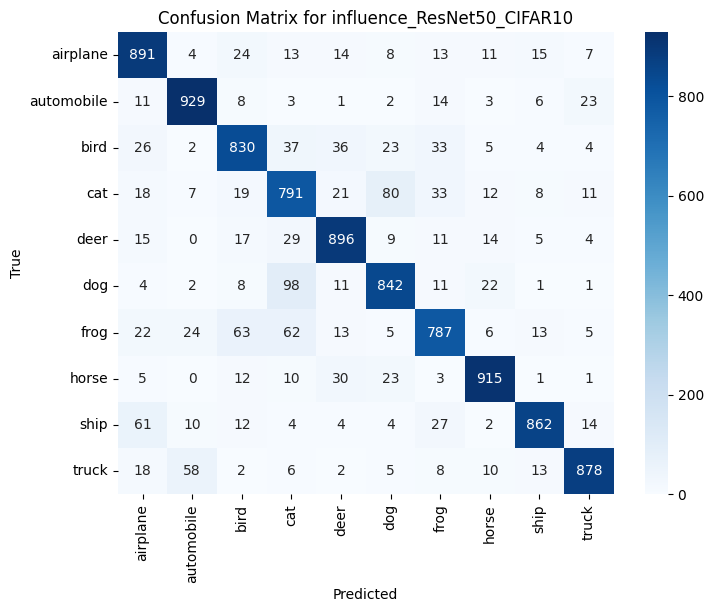

In [21]:
predictions_path = results_path / f"{model_to_unlearn_name}_predictions.json"
# classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
show_metrics(predictions_path, classes, model_to_unlearn_name)